In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [4]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean = df_clean_column.dropna(axis = 0)

In [5]:
pm_class = np.unique(df_clean['pmmet'])
pm_value = [sum(df_clean['pmmet']==pm_class[0]),
            sum(df_clean['pmmet']==pm_class[1])]
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sm = SMOTE(random_state=1)
X_res, Y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res,Y_res,test_size=0.2,random_state=0)

print(X_res.shape,Y_res.shape)

(2556, 14) (2556,)


In [7]:
# fs = SelectKBest(chi2, k=2)
# fs.fit(X_train,y_train)
# X_train = fs.transform(X_train)
# X_test = fs.transform(X_test)


In [8]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Logis

In [9]:
# from sklearn import svm
# clf = svm.SVC(kernel='linear', C=5).fit(X_train, y_train)
# clf.score(X_test, y_test)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
params = {'C': [1, 2, 6, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 1}
10CV accuracy : 76.17479674796748


In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 78.7109375


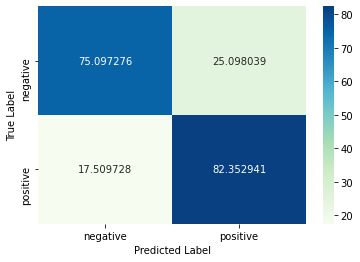

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [13]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.75      0.78       257
    positive       0.77      0.82      0.79       255

    accuracy                           0.79       512
   macro avg       0.79      0.79      0.79       512
weighted avg       0.79      0.79      0.79       512



SVM

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 15, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 4, 'gamma': 15}
10CV accuracy : 89.23720707795313


In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.912109375

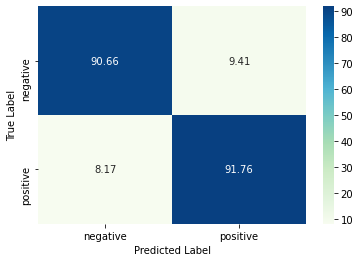

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [17]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.92      0.91      0.91       257
    positive       0.91      0.92      0.91       255

    accuracy                           0.91       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.91      0.91      0.91       512



random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200,500],
    'min_samples_leaf' : [1,2,4,8,16,32],
    'max_features' : ['sqrt',0.5,0.8],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
10CV accuracy : 91.29124820659969


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.90625

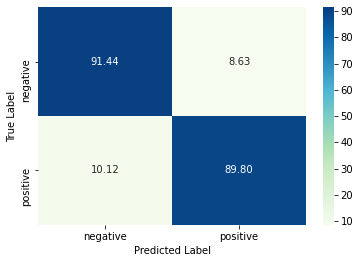

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [21]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.91       257
    positive       0.91      0.90      0.91       255

    accuracy                           0.91       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.91      0.91      0.91       512



XG Boost

In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200],
    'max_depth' : [2, 4, 8],
    'learning_rate' : [0.001, 0.01, 0.1],
    'subsample' : [0.5,0.8, 1],
    'colsample_bytree' : [0.5, 0.8, 1]    
}
clf = GridSearchCV(xgb.XGBClassifier(random_state=0, objective='binary:logistic',n_jobs=-1),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'subsample': 1}
10CV accuracy : 90.26279292204687


In [23]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.908203125

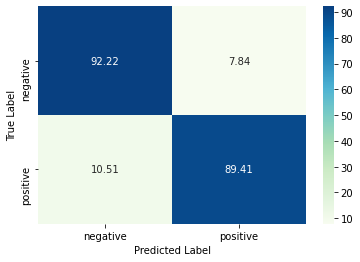

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [25]:

print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.92      0.91       257
    positive       0.92      0.89      0.91       255

    accuracy                           0.91       512
   macro avg       0.91      0.91      0.91       512
weighted avg       0.91      0.91      0.91       512



cat boost

In [26]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from datetime import datetime
params = {
    'iterations' : [200,500],
    'depth' : [9,10,11,12],
    'learning_rate':[0.9,1],  
}
start=datetime.now()
clf = GridSearchCV(CatBoostClassifier(random_state=0,verbose=False),params, cv = 10)
clf.fit(X_train_norm, y_train)
print('best params search time: '+str(datetime.now()-start))
print("Best params : " + str(clf.best_params_))

print("10CV accuracy : "+str(clf.best_score_*100))

best params search time: 0:38:12.039211
Best params : {'depth': 10, 'iterations': 500, 'learning_rate': 0.9}
10CV accuracy : 90.70492587278814


In [27]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
start = datetime.now()
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
runtime = datetime.now()-start

print('test runtime: '+ str(runtime))
sum(y_test == y_predict)/len(y_test)

test runtime: 0:00:00.006099


0.8984375

print(classification_report(y_test, y_predict, target_names=target_names))

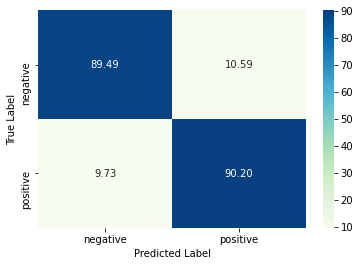

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()